# Agent-Based Model to Simulate Transition Between Stages of JC

The frequencies of the different forms seem to be directly related to the ranking values of the constraints. This makes it possible to learn from data with specific frequencies. 

This in turns allows to reproduce the change in dominant grammar on a population level across generations through an **iterated learning simulation** (Kirby & Hurford, 2002) where agents learn from the productions of the immediately preceding generation. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from saot import *

## GLA

The iterated leaning simulation uses the **Gradual Learning Algoritm** (Boersma, 1997) to model the learning procedure. It works as follows:
When the learner's prediction differs from the observed target, the ranking values of the constraints in the learner's grammar are updated by:
- **increasing** the ranking of constraints that favor the target form, and
- **decreasing** the ranking of constraints that favor the learner's erroneous form.

In [ ]:
# ----- Example usage of GLA update -----
grammar = {faith_neg: 4.0, star_neg: 3.0, neg_first: 2.0, neg_last: 1.0}

print(f"Initial grammar:\t{grammar_dict_to_readable(grammar)}")
h_name = get_hierarchy_name(grammar)
hierarchy = HIERARCHIES_DICT[h_name]
k_values = [grammar[c] for c in hierarchy]
hierarchy_formatted = " >> ".join(c.__name__ for c in hierarchy)
print(f"\t   Hierarchy {h_name[-1]}: {hierarchy_formatted}\n\t      K-values: {k_values}")

for id in range(5):  # multiple updates
    grammar_updated = gla_update(
        grammar,
        predicted_sf=['SN', 'V'],
        observed_sf=['V', 'SN']
    )
    grammar = grammar_updated 
    print(f"\nGrammar after update {id + 1}: {grammar_dict_to_readable(grammar)}")
    h_name = get_hierarchy_name(grammar)
    hierarchy = HIERARCHIES_DICT[h_name]
    k_values = [grammar[c] for c in hierarchy]
    hierarchy_formatted = " >> ".join(c.__name__ for c in hierarchy)
    print(f"\t   Hierarchy {h_name[-1]}: {hierarchy_formatted}\n\t      K-values: {k_values}")

## Agent Class

An agent equipped with:
- **an OT grammar** (the model of its competence): A set of constraints with associated K-values.
- **an SA-OT production procedure** (model of performance): The agent can produce surface forms based on its grammar using the SAOT algorithm.
- **a GLA learning procedure** (Boersma, 1997; see implementation above): The agent can update its grammar based on observed surface forms. 

In [ ]:
# ----- Example usage of SAOTAgent -----
adult_agent = SAOTAgent(id=0, hierarchy_name='H1', k_values='random')
print(f"Initial agent:\n\t{adult_agent}")

new_agent = SAOTAgent(id=1, hierarchy_name='H6', k_values='random')

iter = 0
while new_agent.hierarchy_name != adult_agent.hierarchy_name:
    iter += 1
    target_sf = adult_agent.produce_sf()  # Adult agent produces a surface form based on the current grammar
    print(f"\nNew agent is learning from target surface form: {serialize_sf(target_sf, flat=True)}...")
    new_agent.learn_from(target_sf) 
    print(f"New gent after learning iteration {iter}:\n\t{new_agent}")

# 1 Simulation Run

In [ ]:
model = SAOTModel(
    pop_size=5, 
    generations=1000, 
    gen0_hierarchy_name='H1', 
    k_values='random',
    learning_data_size=30, 
    productions_per_agent=100
    )

model.run()

In [ ]:
model.plot_history() 

# Multiple Simulation Runs

In [ ]:
import multiprocessing as mp
import time

In [ ]:
def run_single_simulation_with_progress(args):
    """Run simulation with unpacked arguments and progress tracking."""
    sim_id, params = args
    start_time = time.time()
    
    print(f"Starting simulation {sim_id + 1}/{params['n_total']}...")
    
    model = SAOTModel(pop_size=params['pop_size'], 
                  generations=params['generations'],
                  gen0_hierarchy_name=params['gen0_hierarchy_name'],
                  learning_data_size=params['learning_data_size'],
                  productions_per_agent=params['productions_per_agent'],
                  seed=42 + sim_id)
    
    model.run()
    
    elapsed = time.time() - start_time
    print(f"Simulation {sim_id + 1} completed in {elapsed:.1f}s")
    
    return model.production_history

In [ ]:
# ----- Parameters -----
n_simulations = 20

params = {
    'pop_size': 5,
    'generations': 100,
    'gen0_hierarchy_name': 'H1',
    'k_values': 'random',  
    'learning_data_size': 30,
    'productions_per_agent': 100,
    'n_total': n_simulations
}

# ----- Run simulations in parallel -----
if __name__ == '__main__':
    n_processes = min(n_simulations, mp.cpu_count())
    print(f"Running {n_simulations} simulations on {n_processes} processes...")
    
    # Prepare arguments for each simulation
    simulation_args = [(i, params) for i in range(n_simulations)]
    
    start_time = time.time()
    with mp.Pool(processes=n_processes) as pool:
        histories = pool.map(run_single_simulation_with_progress, simulation_args)
    
    total_time = time.time() - start_time
    print(f"All simulations completed in {total_time:.1f}s")

Mean Proportions:
[SN V SN SN]    0.0001
[SN V SN]       0.2385
[SN V]          0.5085
[V SN]          0.2529
dtype: float64


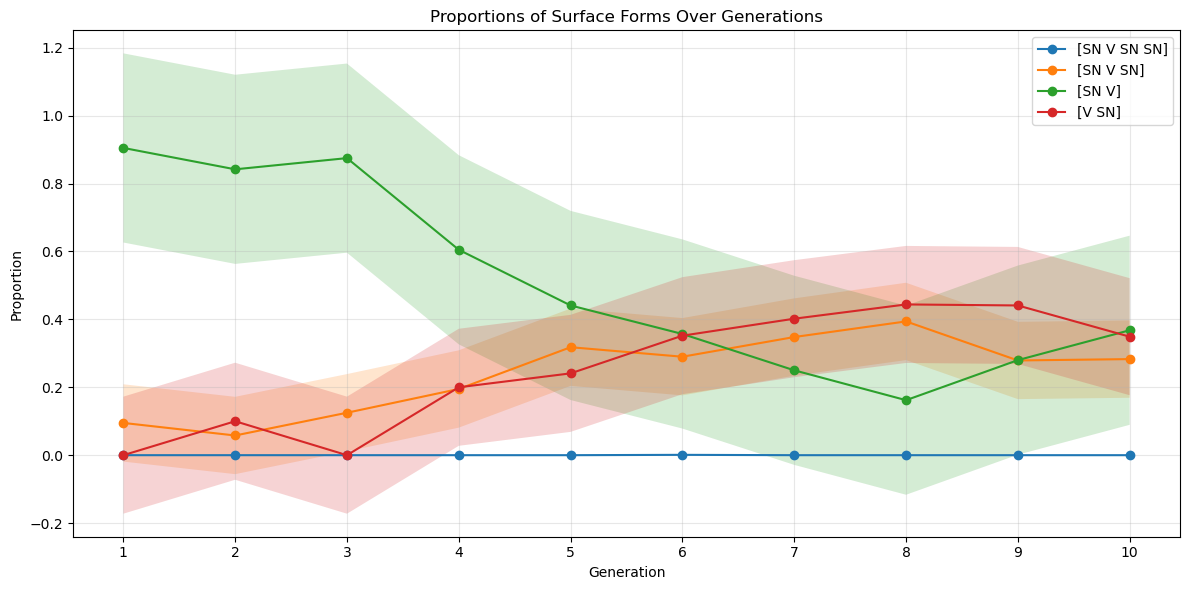

In [ ]:
# ----- Combine results -----
all_generations = {}

for history in histories:
    for gen, productions in history.items():
        if gen not in all_generations:
            all_generations[gen] = []
        all_generations[gen].extend(serialize_sf(sf, flat=True) for sf in productions)

# Convert to DataFrame
all_generations_df = pd.DataFrame(all_generations)

# Count occurrences of each surface form
counts = all_generations_df.apply(lambda x: x.value_counts()).fillna(0) 

# Convert counts to proportions
proportions = counts.apply(lambda x: x / x.sum(), axis=0)

# Calculate mean and std deviation across simulations
mean_proportions = proportions.mean(axis=1)
std_proportions = proportions.std(axis=1)

print(f"Mean Proportions:\n{mean_proportions}")

# ----- Plot aggregate results -----
plt.figure(figsize=(12, 6))

# Get generations (x-axis) from proportions columns
generations = proportions.columns
x_axis = range(len(proportions.columns))

for sf in proportions.index:  # Iterate over surface forms
    sf_proportions = proportions.loc[sf].values  # Get array of proportions across generations
    sf_mean = mean_proportions[sf]  # This is still a single value
    sf_std = std_proportions[sf]   # This is still a single value
    
    plt.plot(x_axis, sf_proportions, label=sf)
    plt.fill_between(x_axis, 
                    sf_proportions - sf_std, 
                    sf_proportions + sf_std, 
                    alpha=0.2)

plt.title("Proportions of Surface Forms Over Generations")
plt.xlabel("Generation")
plt.ylabel("Proportion")
plt.xticks(x_axis, generations)  # Label x-axis with actual generation numbers
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()